In [1]:
import pandas as pd
import numpy as np
import yaml
from h3 import h3
from sklearn.cluster import DBSCAN
from sqlalchemy import create_engine
import psycopg2
import geopandas as gpd
from shapely.geometry import Polygon, LineString


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
resolucion = 11
tolerancia_metros = 5000
distancia_entre_hex = h3.edge_length(resolution=resolucion, unit='m') * 2 
tolerancia_hex = np.ceil(tolerancia_metros / distancia_entre_hex)
tolerancia_hex

101.0

In [3]:
# Analizar los tramos del subte 

In [4]:
DB_USERNAME = 'sube_user'
DB_PASSWORD = 'sube_pass'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'sube'
DB_SCHEMA = 'public'

# Conectar a la db
conn = psycopg2.connect(user = DB_USERNAME,
                                      password = DB_PASSWORD,
                                      host = DB_HOST,
                                      port = DB_PORT,
                                      database = DB_NAME)


engine = create_engine('postgresql://{}:{}@{}:{}/{}'
    .format(DB_USERNAME, DB_PASSWORD, DB_HOST,
            DB_PORT, DB_NAME))

In [5]:
q = """
select *
from tramos_linea_b t 
where tarjeta in (
    with mask_table as (
        select tarjeta,count(tarjeta) = SUM(CASE when h3_d  IS NULL THEN 0 else 1 END) as mask
        from tramos_linea_b tlb 
        group by tarjeta
    )
    select tarjeta
    from mask_table
    where mask = true
)
order by tarjeta, tramo_id;
"""
tramos = pd.read_sql(q, conn)

In [6]:
q = """
select nombre,h3_res_%i
from paradas p
where modo = 'SUB'
"""%resolucion
paradas = pd.read_sql(q, conn)
paradas.head()

,nombre,h3_res_11
0,9 DE JULIO | Linea D,8bc2e31132a2fff
1,CASEROS | Linea H,8bc2e3115133fff
2,INCLAN | Linea H,8bc2e31150c9fff
3,HUMBERTO 1° | Linea H,8bc2e311191dfff
4,VENEZUELA | Linea H,8bc2e3111a84fff


In [7]:
solo_subte = (tramos.h3_o.isin(paradas.h3_res_11)) & (tramos.h3_d.isin(paradas.h3_res_11))

In [8]:
tramos_subte = tramos.loc[solo_subte,:]

In [9]:
tramos_subte = tramos_subte.merge(paradas,left_on = 'h3_o',right_on = 'h3_res_11',how='left')
tramos_subte.drop('h3_res_11',axis =1,inplace=True)
tramos_subte.rename(columns = {'nombre':'estacion_origen'},inplace=True)

tramos_subte = tramos_subte.merge(paradas,left_on = 'h3_d',right_on = 'h3_res_11',how='left')
tramos_subte.drop('h3_res_11',axis =1,inplace=True)
tramos_subte.rename(columns = {'nombre':'estacion_destino'},inplace=True)

In [10]:
tramos_subte.shape

(261654, 14)

In [11]:
tabla = pd.crosstab(tramos_subte.estacion_origen,tramos_subte.estacion_destino)
suma_origenes = tabla.sum(axis=1).sort_values(ascending=False)
suma_destinos = tabla.sum(axis=0).sort_values(ascending=False)
tabla = tabla.reindex(index=suma_origenes.index)
tabla = tabla.reindex(columns=suma_destinos.index)
tabla = tabla.replace(0,np.nan).dropna(how='all')

In [51]:
suma_origenes.head(30)

estacion_origen
FEDERICO LACROZE | Linea B              22637
JUAN MANUEL DE ROSAS | Linea B          20640
FLORIDA | Linea B                       16161
MALABIA - OSVALDO PUGLIESE | Linea B    15770
CALLAO | Linea B                        15019
MEDRANO | Linea B                       13774
LEANDRO N. ALEM | Linea B               13034
ANGEL GALLARDO | Linea B                12248
URUGUAY | Linea B                       11997
CARLOS GARDEL | Linea B                 10268
PASTEUR - AMIA | Linea B                 9360
DE LOS INCAS -PQUE. CHAS | Linea B       8321
C. PELLEGRINI | Linea B                  7906
DORREGO | Linea B                        7789
CONSTITUCION | Linea C                   5873
ECHEVERRÍA | Linea B                     5835
PUEYRREDON | Linea B                     5572
CORRIENTES | Linea H                     5572
TRONADOR - VILLA ORTÚZAR | Linea B       4832
CATEDRAL | Linea D                       3103
PUEYRREDON | Linea D                     2163
INDEPENDENCIA | Li

In [45]:
linea_color = {' Linea B':'Red',
               ' Linea C':'Blue',
               ' Linea H':'Gold',
               ' Linea D':'Green',
               ' Linea E':'Purple',
               ' Linea A':'Lighblue',
               ' Linea PREMETRO':'Brown'
              }

In [46]:
color_origenes = pd.Series(map(lambda s:linea_color[s.split('|')[1]],suma_origenes.index),index=suma_origenes.index)
color_destinos = pd.Series(map(lambda s:linea_color[s.split('|')[1]],suma_destinos.index),index=suma_destinos.index)

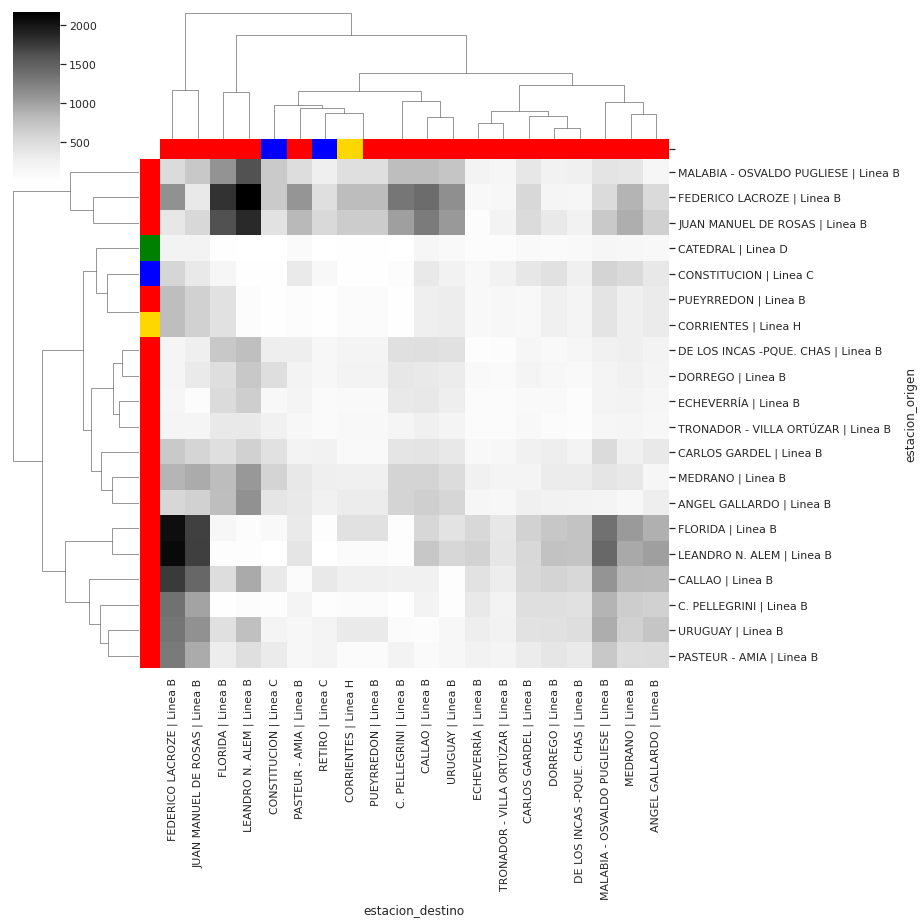

In [48]:
sns.clustermap(tabla.iloc[:20,:20],
               row_colors=color_origenes, col_colors=color_destinos,
               cmap="Greys",figsize=(13, 13))

In [ ]:
q = """
select *
from viajes_linea_b
"""
viajes = pd.read_sql(q, conn)

In [ ]:
tramos.linea.value_counts()

In [ ]:
viajes.loc[viajes.tarjeta == 1656044]

In [ ]:
viajes_1tramo = viajes.loc[(viajes.tramos==1) & (viajes.h3_d.notnull()) ,:]

In [ ]:
viajes_1tramo.linea.value_counts()

In [ ]:
viajes_1tramo[viajes_1tramo.linea=='LINEA 580']

In [ ]:
viajes_1tramo.head()

In [ ]:
distancia_tramos = []
distancia_viajes = []
for i,row in viajes_1tramo.head().iterrows():
    distancia_viajes.append(h3.h3_distance(h3_address_origin = row.h3_o,
                                           h3_address_h3 = row.h3_d))

In [ ]:
distancia

In [ ]:
viajes_1tramo.head(6)